<a href="https://colab.research.google.com/github/elolaine/AI4Biologists/blob/main/notebooks/PLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from os import path
import pandas as pd
import numpy as np
from numpy import asarray
import seaborn as sns
import matplotlib.pyplot as plt
import gc
from sklearn.manifold import TSNE #t-sne for data visualisation of the embedding vectors
import time
from tqdm.keras import TqdmCallback
import h5py

#### Retrieve the data: fasta sequences and labels (Pfam family)

In [ ]:
!gdown --id '1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG'
!gdown --id '1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W'

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ZRKQdrYu0tCT7kW-tmbpJ3N9ov9igbQG
To: /content/input.fasta
100% 42.0k/42.0k [00:00<00:00, 59.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Me9zJth8PV7z4LCYttjVNQnEwBMD9K4W
To: /content/input.csv
100% 43.8k/43.8k [00:00<00:00, 46.3MB/s]


# The protein language model (from Bepler and Berger 2019)

In [ ]:
!git clone https://github.com/tbepler/prose.git

Cloning into 'prose'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 26 (delta 1), reused 23 (delta 1), pack-reused 0
Unpacking objects: 100% (26/26), done.


In [ ]:
!wget -nc -P prose/ http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip

--2022-07-24 10:48:38--  http://bergerlab-downloads.csail.mit.edu/prose/saved_models.zip
Resolving bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)... 128.30.48.147
Connecting to bergerlab-downloads.csail.mit.edu (bergerlab-downloads.csail.mit.edu)|128.30.48.147|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 581846360 (555M) [application/zip]
Saving to: ‘prose/saved_models.zip’

saved_models.zip    100%[===================>] 554.89M  11.8MB/s    in 50s     

2022-07-24 10:49:29 (11.1 MB/s) - ‘prose/saved_models.zip’ saved [581846360/581846360]



In [ ]:
!unzip -q -n prose/saved_models.zip -d prose/

In [ ]:
#!pip install -r prose/requirements.txt

Extract the embeddings

In [ ]:
!python3 prose/embed_sequences.py --pool avg -o prose/data/output.h5 /content/input.fasta

# loading the pre-trained ProSE MT model
# writing: prose/data/output.h5
# embedding with pool=avg


In [ ]:
hf_embeddings = h5py.File('prose/data/output.h5', 'r')
embeddings = {x: np.array(hf_embeddings[x]) for x in df.UniprotId.to_list()}

In [ ]:
print(list(embeddings.keys())[:10])
print(list(df.UniprotId.to_list())[:10])

['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']
['A0A671VDZ5/18-86', 'A0A2T4H7P2/23-88', 'A0A2A3EG26/7-35', 'A0A384DIE7/467-542', 'A0A481BKW6/137-162', 'A0A3P9DKY7/475-591', 'A0A316YP75/8-46', 'A0A2R8PDT9/22-91', 'A0A6J2WFH4/12-52', 'A0A6J0SWF7/652-705']


In [ ]:
embeddings

{'A0A009H247/15-197': array([ 0.07103825,  0.09289617,  0.04918033, ..., -0.1769829 ,
         0.096926  , -0.03266132], dtype=float32),
 'A0A023EYB3/10-39': array([0.03333334, 0.03333334, 0.10000001, ..., 0.03043235, 0.58849466,
        0.15352643], dtype=float32),
 'A0A034VB09/503-958': array([ 0.04385965,  0.04824562,  0.08552632, ..., -0.09813451,
         0.1318219 ,  0.18098514], dtype=float32),
 'A0A066VI21/521-848': array([ 0.09451219,  0.07012195,  0.03658536, ..., -0.13972226,
         0.05212694,  0.20910423], dtype=float32),
 'A0A068UTM8/395-755': array([ 0.05263158,  0.08310249,  0.03047091, ..., -0.09161443,
         0.26075813,  0.02244412], dtype=float32),
 'A0A080ZFV1/81-106': array([0.03846154, 0.11538462, 0.03846154, ..., 0.01711943, 0.40131995,
        0.11285767], dtype=float32),
 'A0A091NBP7/13-81': array([4.3478262e-02, 7.2463766e-02, 2.8985508e-02, ..., 4.4384632e-02,
        8.6190850e-02, 4.6692898e-05], dtype=float32),
 'A0A093IYH3/2-76': array([ 0.08      , 

In [ ]:
X = np.vstack(list(embeddings.values()))

Analyze the embeddings

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


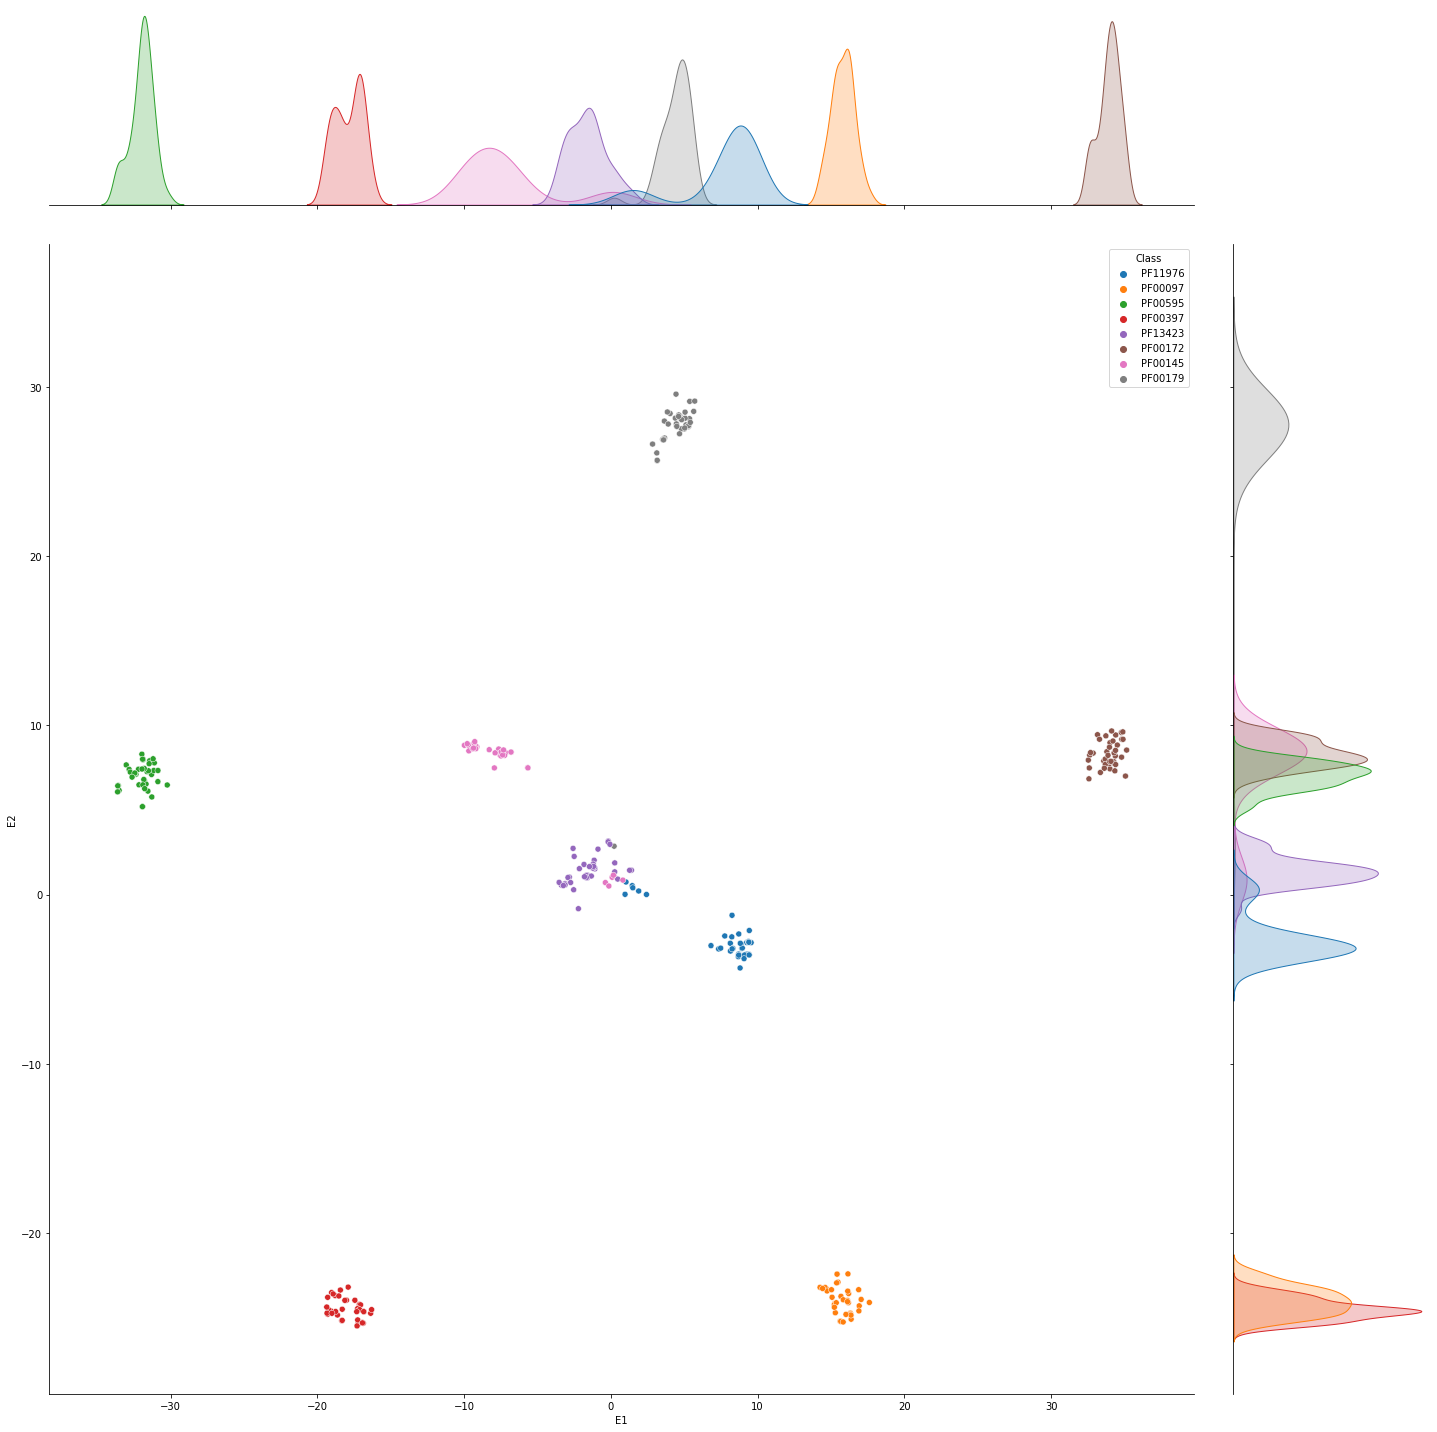

In [ ]:
X_embedded = TSNE(n_components=2,random_state=42).fit_transform(X)

df['E1'] = X_embedded[:,0]
df['E2'] = X_embedded[:,1]

#plt.rcParams.update({'font.size': 10})
sns.jointplot(data=df, x='E1', y='E2', hue = 'Class', height=20)
#sns.jointplot(data=df, x='E1', y='E2', height=10)

In [ ]:
df_new = df[(df.E1.between(20,30)) & (df.E2.between(0,5))]
df_new

Empty DataFrame
Columns: [UniprotId, Seq, Class, E1, E2]
Index: []

In [ ]:
X_embedded

array([[ 9.37225151e+00, -3.50894403e+00],
       [ 8.70446205e+00, -3.51018596e+00],
       [ 1.76092377e+01, -2.40956860e+01],
       [-3.14253254e+01,  7.90774822e+00],
       [-1.92918606e+01, -2.47875462e+01],
       [-1.77360803e-01,  3.16674042e+00],
       [ 3.40054169e+01,  7.42848206e+00],
       [ 9.25701141e+00, -2.82563019e+00],
       [ 1.56738052e+01, -2.37343979e+01],
       [-3.35049667e+01,  6.15897036e+00],
       [ 3.50590172e+01,  7.00421715e+00],
       [ 8.86810970e+00, -2.90420890e+00],
       [-1.86290264e+01, -2.48371754e+01],
       [-5.66632366e+00,  7.49771452e+00],
       [ 9.41889286e+00, -3.56406975e+00],
       [ 3.51376152e+01,  8.53960228e+00],
       [-1.83045940e+01, -2.44951725e+01],
       [-3.17879601e+01,  6.74131298e+00],
       [ 1.61196041e+01, -2.39770756e+01],
       [-9.12891197e+00,  8.72942352e+00],
       [ 3.37233543e+01,  9.38035679e+00],
       [ 2.21851453e-01,  1.10496473e+00],
       [-1.60308361e+00,  9.91000295e-01],
       [ 3.

Designed by Yasser MOHSENI BEHBAHANI and Élodie LAINE, LCQB, Sorbonne Université, 2022

<img src='https://drive.google.com/uc?id=1shvaqXgnRa2aCji30gJ02hwI_Ux6NEp6'>